<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели картинку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота )))))
5. Whatever comes to your head

# Предобработка текстов из датасета

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!tar -xvzf '/content/gdrive/My Drive/Image Captioning/handout.tar (1).gz'

data/
data/captions_tokenized.json
data/image_codes.npy


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
import json

# Загрузим датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [0]:
# Посмотрим на элемент датасета
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлых занятиях. Батч должен выглядеть примерно так:

```
[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,    2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,    2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,  393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
```
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезаются, в начале и конце по коду символа начала и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

Разделим датасет на Train и Val:

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

Посчитаем частоту встречаемости слов в captions:

In [0]:
from collections import Counter
token_counts = Counter()

for cap in train_captions:
  for line in cap:
        token_counts.update(line.split())

In [0]:
token_counts.most_common(10)

[('a', 880595),
 ('.', 400192),
 ('on', 194324),
 ('of', 183429),
 ('the', 178014),
 ('in', 165666),
 ('with', 139145),
 ('and', 126488),
 ('is', 88471),
 ('man', 65783)]

Загрузим предобученные эмбеддинги:

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip #https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip #https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-02-22 05:29:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  20.6MB/s    in 63s     

2020-02-22 05:30:28 (23.1 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip '/content/crawl-300d-2M.vec.zip' #wiki-news-300d-1M.vec.zip'

Archive:  /content/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
import gensim

In [0]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(fname='/content/crawl-300d-2M.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Построим словарь токенов:

In [0]:
min_count = 5
tokens = [token for token, num in token_counts.items() if (token in w2v_model and num>=min_count)]

Добавим в словарь специальные символы:

In [0]:
UNK, PAD, BOS, EOS = "UNK", "PAD", "<bos>", "<eos>"
tokens = [PAD, BOS, EOS, UNK] + tokens

In [0]:
n_tokens = len(tokens)

In [0]:
n_tokens

9822

Подготовим словарь для перевода токенов в индексы:

In [0]:
token_to_id = {t:i for i, t in enumerate(tokens)}

In [0]:
UNK_IDX, PAD_IDX = token_to_id["UNK"], token_to_id["PAD"]
BOS_IDX, EOS_IDX = token_to_id["<bos>"], token_to_id["<eos>"]

Из эмбеддингов слов из словаря сформируем таблицу для передачи в слой nn.Embedding:

In [0]:
numpy_embeddings = np.zeros(shape=[len(tokens), 300],dtype=np.float32)

for word in tokens:
    if word in w2v_model:
        vector = w2v_model.get_vector(word)
        index  = token_to_id[word]
        numpy_embeddings[index] = vector
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([9822, 300])

In [0]:
#  Преобразование предложений в матрицу индексов с паддингами
def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        max_len: if specified, 
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len+2), np.int32(PAD_IDX))
    for i,seq in enumerate(sequences):
        row_ix = [BOS_IDX] + [token_to_id.get(word, UNK_IDX) for word in seq[:max_len]] + [EOS_IDX]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Посмотрим, какой длины предложения есть в нашем датасете. Это поможет нам с выбором max_len для генерации.

In [0]:
lens = []
for cap in captions:
  for str_cap in cap:
    lens.append(len(str_cap.split()))

In [0]:
np.mean(lens), np.min(lens), np.max(lens)

(11.292223152163805, 6, 57)

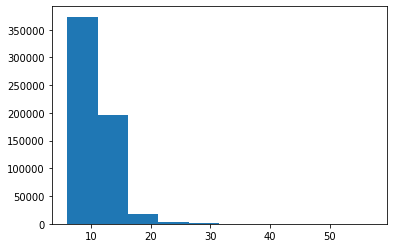

In [0]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

Подавляющее большинство предложений не превосходит длины 30 токенов.

## Подготовка references для расчета BLEU


In [0]:
batch_size = 32

In [0]:
# При валидации не будем учитывать последний неполный батч
val_size = len(val_captions) // batch_size * batch_size

In [0]:
# Для расчета bleu
references = []
for cap in val_captions[:val_size]:
  new_cap = []
  for str_cap in cap:
    new_cap.append(list(str_cap.split()))
  references.append(new_cap)

In [0]:
references[0][0]

['two', 'pizzas', 'that', 'are', 'sitting', 'on', 'a', 'stove', '.']

In [0]:
np.array(references).shape

(11808, 5)

# Построение модели

Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens

        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words 
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=PAD_IDX) 
        self.drop = nn.Dropout(0.4) 
            
        # lstm
        self.lstm = nn.LSTMCell(emb_size, lstm_units) 

        # Линейный слой для подобия attention
        self.fc_2 = nn.Linear(lstm_units, cnn_feature_size)
        self.drop_2 = nn.Dropout(0.2)       
            
        # Линейный слой для получения логитов
        self.fc = nn.Linear(cnn_feature_size + lstm_units, n_tokens)  

        self.init_weights()
        
    def forward(self, image_vectors, captions_ix=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch_size, cnn_feature_size]
        :param captions_ix: [batch_size, max_len]
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch_size, max_len, n_tokens]
        """
        batch_size = image_vectors.shape[0]
        
        if captions_ix is None:
          max_len = 30
        else:
          max_len = captions_ix.shape[1]
        
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.n_tokens).to(device)

        # init h0 and c0
        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)) 
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            # (batch_size, emb_size)
            lstm_in = self.drop(self.embed(captions_input)) 

            # (batch_size, lstm_units)
            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            # Из hidden получаем  своеобразные веса для компонент эмбеддинга картинки
            # (batch_size, cnn_feature_size)
            lstm_out_1 = torch.sigmoid(self.fc_2(hidden))

            # Умножаем эмбеддинг картинки на полученные веса
            # (batch_size, cnn_feature_size)
            att = lstm_out_1 * image_vectors

            # Окончательный результат получаем из конкатенации
            # hidden и взвешенного эмбеддинга картинки
            # (batch_size, n_tokens)
            output = self.fc(self.drop_2(torch.cat((att, hidden), -1)))

            outputs[:, t, :] = output

            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
              captions_input = captions_ix[:, t] 
            else:
              captions_input = output.argmax(-1) 
        
        return outputs[:, 1:]

    def sample(self, image_vectors, max_len=None, st=1):

        batch_size = image_vectors.shape[0]
        
        if max_len is None:
          max_len = 30
        
        # list to store decoder outputs
        sentence = []

        # init h0 and c0
        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)) 
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_in = self.drop(self.embed(captions_input)) 

            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            lstm_out_1 = torch.sigmoid(self.fc_2(hidden))

            att = lstm_out_1 * image_vectors

            output = self.fc(torch.cat((att, hidden), -1))

            next_word_probs = F.softmax(output[0], dim=-1).data.cpu().numpy()

            next_word_probs = next_word_probs ** st / np.sum(next_word_probs ** st)

            next_word = np.random.choice(tokens, p=next_word_probs)

            if next_word == EOS:
                break

            sentence.append(next_word)

            captions_input[0] = token_to_id[next_word]
        
        return (' ').join(sentence)

    def beam_search(self, image_vectors, top_k=3, max_len=None):
        
        if max_len is None:
          max_len = 30
        
        # Чтобы параллельно хранить top_k последовательностей, положим batch_size=top_k

        # lists to store completed sequences and their scores
        complete_seqs = list()
        complete_seqs_scores = list()

        prev_word_probs = torch.zeros(top_k, 1).to(device)

        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)).repeat(top_k, 1) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)).repeat(top_k, 1) 
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((top_k,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_in = self.drop(self.embed(captions_input)) 

            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            lstm_out_1 = torch.sigmoid(self.fc_2(hidden))

            att = lstm_out_1 * image_vectors.repeat(top_k, 1)

            output = self.fc(torch.cat((att, hidden), -1))

            # (top_k, n_tokens)
            # log_softmax, чтобы складывать вероятности
            next_word_probs = F.log_softmax(output, dim=-1)

            # Находим вероятности всего построенного префикса предложения
            next_word_probs = prev_word_probs.expand_as(next_word_probs) + next_word_probs

            if t == 1:
                # Все строки пока одинаковые, поэтому берем только одну
                prev_word_probs, topk_indices = torch.topk(next_word_probs[0], top_k)
            else:
                # Среди всех top_k * n_tokens вероятностей находим top_k максимальных
                next_word_probs = next_word_probs.view(-1)
                prev_word_probs, topk_indices = torch.topk(next_word_probs, top_k)

            # Найдем номера исходных строк - префиксов предложений
            prev_topk_indices = topk_indices / self.n_tokens
            # Найдем номера полученных следующих слов
            next_topk_indices = topk_indices % self.n_tokens

            if t == 1:
                # Полученные слова будут первыми в предложениях
                seqs = next_topk_indices.unsqueeze(1)
            else:
                # Добавим полученные слова к имеющимся префиксам предложений
                seqs = torch.cat([seqs[prev_topk_indices], next_topk_indices.unsqueeze(1)], dim=1)

            if t == max_len-1:
                # Считаем все последовательности законченными
                incomplete_inds = []
            else:
                # Ищем те, у которых следующий символ не <eos>
                incomplete_inds = [ind for ind, next_word in enumerate(next_topk_indices) if
                                  next_word != EOS_IDX]
            complete_inds = list(set(range(len(next_topk_indices))) - set(incomplete_inds))

            # Обновим информацию о завершенных последовательностях и их вероятностях
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(next_word_probs[complete_inds].tolist())

            # Уменьшаем размер луча
            top_k -= len(complete_inds)  

            if top_k == 0:
                break
            # Продолжаем только с незаконченными последовательностями
            seqs = seqs[incomplete_inds]
            hidden = hidden[prev_topk_indices[incomplete_inds]]
            cell = cell[prev_topk_indices[incomplete_inds]]
            prev_word_probs = prev_word_probs[incomplete_inds].unsqueeze(1)
            captions_input = next_topk_indices[incomplete_inds] 

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i] 
        
        # Возвращаем самую вероятную последовательность - seq
        # А также все top_k построенных последовательностей - complete_seqs
        return seq, complete_seqs 

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.08, 0.08)       

In [0]:
network = CaptionNet(n_tokens, emb_size=300, lstm_units=512)

In [0]:
network

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=512, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=512, bias=True)
  (embed): Embedding(9822, 300, padding_idx=0)
  (drop): Dropout(p=0.4, inplace=False)
  (lstm): LSTMCell(300, 512)
  (fc_2): Linear(in_features=512, out_features=2048, bias=True)
  (drop_2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=2560, out_features=9822, bias=True)
)

In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25000, 50000], gamma=0.5)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
network = network.to(device)

# Обучение модели

## Дополнительные процедуры

In [0]:
# batch generator. 
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions, max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [0]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# Считает loss и BLEU на валидационном датасете
def evaluate(model, criterion, max_len=None, val_size=len(val_img_codes)):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size

    random_ind = random.randint(0, val_size-1)
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            image_vectors, captions_ix_all = val_img_codes[i:i+batch_size], train_captions[i:i+batch_size]
            captions_ix = as_matrix(captions_ix_all[:, 0], max_len)
            
            image_vectors, captions_ix = torch.tensor(image_vectors, dtype=torch.float32).to(device), torch.tensor(captions_ix, dtype=torch.int64).to(device) #image_vectors.to(device), captions_ix.to(device)

            captions_ix_next = captions_ix[:, 1:].contiguous()
        
            outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=0.)

            loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
            
            epoch_loss += loss.item()

            outputs_max = outputs.argmax(-1)
            for out in outputs_max:
              hypotheses.append(translate(out.tolist(), to_str=False))

            if random_ind in range(i,i+batch_size):
              print('Random example:')
              print('\tTarget: {}'.format(translate(captions_ix_next[random_ind % batch_size].tolist())))
              print('\tOutput: {}'.format(translate(outputs.argmax(-1)[random_ind % batch_size].tolist())))

    print('Fixed example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))

    bleu = corpus_bleu(references, hypotheses)
        
    return epoch_loss / (val_size // batch_size), bleu*100

In [0]:
# Переводит массив индексов в строку/массив с токенами (до первого символа конца строки)
def translate(list_ind, to_str=True):
  
  if EOS_IDX in list_ind:
    max_ind = list_ind.index(EOS_IDX)
  else:
    max_ind = len(list_ind)

  if to_str:
    return (' ').join([tokens[ind] for ind in list_ind[:max_ind]])
  else:
    return [tokens[ind] for ind in list_ind[:max_ind]]

In [0]:
# Выводит график функции потерь и BLEU
def plot_loss():

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,2)
    plt.title("Losses")
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.plot(np.argmin(val_losses), np.min(val_losses), marker="x", color="r", label="best val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()

    plt.subplot(1,2,1)
    plt.title("BLEU")
    plt.plot(bleu, label="val bleu")
    plt.plot(np.argmax(bleu), np.max(bleu), marker="x", color="b", label="best bleu")
    plt.xlabel("Epochs")
    plt.ylabel("BLEU")
    plt.legend()

    plt.show()

Протестируем генерацию батча:

In [0]:
# max_caption_len без учета спец символов для начала и конца предложения
batch = generate_batch(train_img_codes, train_captions, 3, max_caption_len=10)

In [0]:
batch

(tensor([[0.1343, 0.2947, 0.5804,  ..., 0.2546, 0.8458, 0.6929],
         [0.2111, 0.4848, 0.1576,  ..., 0.0642, 0.1898, 0.0943],
         [0.2057, 0.2406, 0.6092,  ..., 0.1846, 0.4031, 0.5560]]),
 tensor([[   1,  210,   62,   17, 2807,   24,  707,   14,  588,   12,    2,    0],
         [   1,   24,   46,  447,   41,   94,   35,   24,  793,    2,    0,    0],
         [   1,   24,  106,   14,    4,   35,   24, 4667,   39,   30,   12,    2]]))

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 2048]), torch.Size([3, 12]))

## Цикл обучения

In [0]:
max_epochs = 75000
batch_size = 32
every_epochs = 1000
clip = 5

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

Epoch : 1000
Train example :
	Target: a big bunch of birds in the middle of the street .
	Output: a person of of people on a middle of a . .
Random example:
	Target: a small brown dog standing next to a mirror in a room .
	Output: a man in a shirt and a white shirt .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella in a field .
Train loss    : 3.9694112384319307
Val loss      : 6.156576385342978
Val bleu      : 17.199720089927954



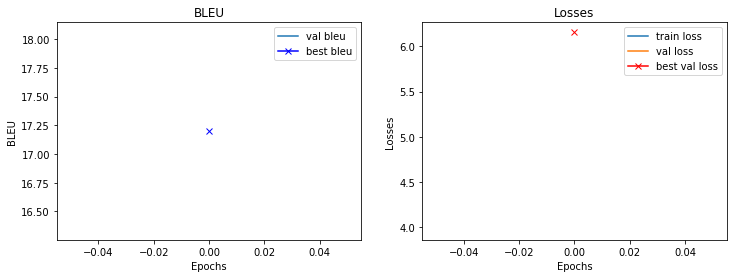

Epoch : 2000
Train example :
	Target: a single bird that sits on a mossy and rocky outcrop .
	Output: a person of is is on a of a water . .
Random example:
	Target: a group of people that are standing around a table .
	Output: a group of people flying kites on a beach .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman with a umbrella walking down a street .
Train loss    : 3.2728288791179656
Val loss      : 6.530798171593891
Val bleu      : 19.61105609147043



Epoch : 3000
Train example :
	Target: a parking meter sitting next to a parked car .
	Output: a parking meter on on a a parking next .
Random example:
	Target: a stream some rocks and people walking on a sidewalk
	Output: a bird flying through a blue sky in a clear sky .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a umbrella in a field with a umbrella .
Train loss    : 3.0746266264915465
Val loss      : 6.807055947580312
Val bleu      : 19.542725868797387



Epoch : 4000
Train example :
	Target: motorcycle parked along brick paved street with shops .
	Output: a parked on a sidewalk road and cars .
Random example:
	Target: a giraffe bending over while standing on green grass .
	Output: a pizza on a plate with a knife and a knife .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella in a park .
Train loss    : 2.970598854780197
Val loss      : 6.964105091766936
Val bleu      : 21.546658330167148



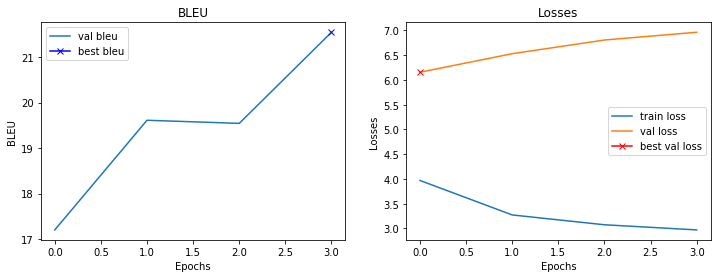

Epoch : 5000
Train example :
	Target: three elephants on dirt road next to trees .
	Output: a elephants elephants a with with to a .
Random example:
	Target: a housing sign is hanging on a telephone pole alongside a road .
	Output: a man holding a bat in a hand .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while holding an umbrella .
Train loss    : 2.9191470820903778
Val loss      : 6.869571172771092
Val bleu      : 21.51417673372262



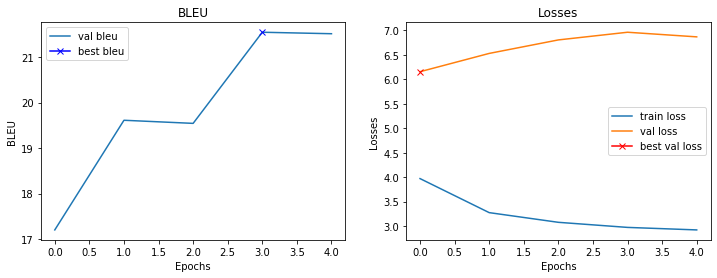

Epoch : 6000
Train example :
	Target: two cats laying near a vase and two candles .
	Output: a cats are on a window of a table .
Random example:
	Target: a dirty toilet has several things lying on the floor near it .
	Output: a young child is playing with a video game .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a backpack and a black umbrella .
Train loss    : 2.852591326236725
Val loss      : 7.060687565222019
Val bleu      : 21.42663057560609



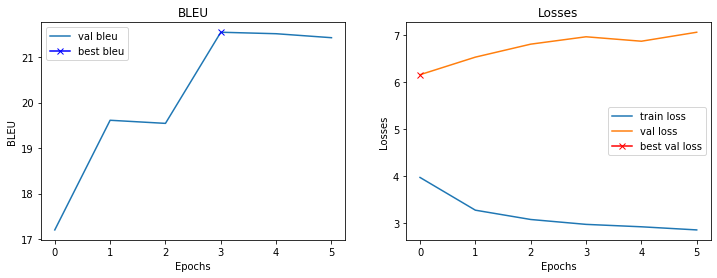

Epoch : 7000
Train example :
	Target: a man pouring a yellow sauce over a container of meat .
	Output: a man is a food bowl of food sandwich . food .
Random example:
	Target: a group of people walk by a line of buses
	Output: a group of people are sitting around a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a umbrella is walking down the street .
Train loss    : 2.7968092613220215
Val loss      : 7.18791584723041
Val bleu      : 21.482679002040587



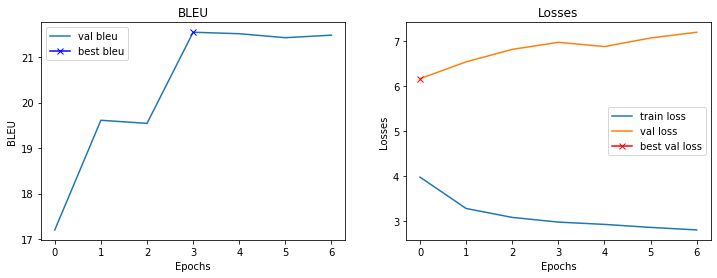

Epoch : 8000
Train example :
	Target: and elderly man riding a motorcycle in the street wearing a helmet
	Output: a people man on on motorcycle on front street . a red .
Random example:
	Target: a bathroom with a white sink next to a toilet paper roller .
	Output: a woman is a kite in the water .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.754713129758835
Val loss      : 7.199628588306871
Val bleu      : 22.729160321707464



Epoch : 9000
Train example :
	Target: a elephant stand among lush trees and grasses .
	Output: a elephant standing in the green in trees .
Random example:
	Target: a fleet of semi trucks driving through orange traffic cones .
	Output: a bus that is parked in the street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a person holding an umbrella in the rain .
Train loss    : 2.7334943177700044
Val loss      : 7.372066479711352
Val bleu      : 22.00348984219732



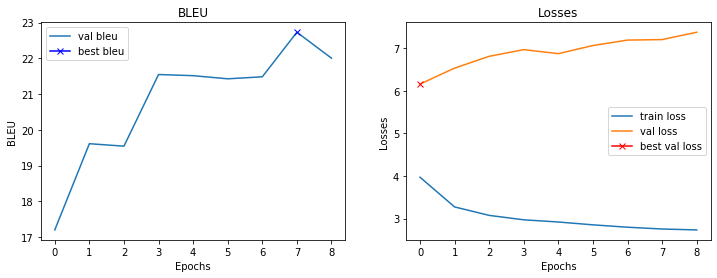

Epoch : 10000
Train example :
	Target: a living room with decorations set up for christmas .
	Output: a living room with a and up and the decorations
Random example:
	Target: a UNK with a funny sign that has burgers saying save me .
	Output: a person on a surfboard on the water .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a colorful umbrella and a black and white umbrella .
Train loss    : 2.7135975801944734
Val loss      : 7.4340628983205574
Val bleu      : 21.432620826810357



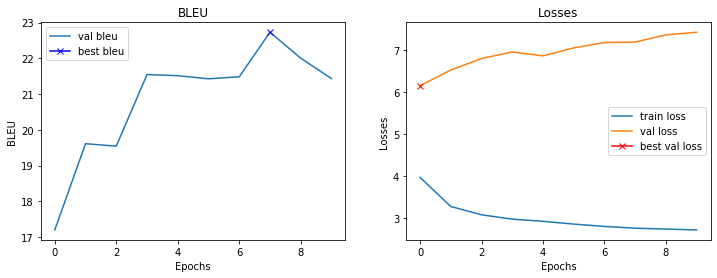

Epoch : 11000
Train example :
	Target: a piano keyboard in front of two computer monitors .
	Output: a computer with has a of a monitors monitors .
Random example:
	Target: a tennis player holds his racket above his head as he waits for the ball
	Output: a man riding a wave on top of a surfboard .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a black shirt and an umbrella
Train loss    : 2.6753782393932344
Val loss      : 7.280899090495536
Val bleu      : 22.775228853289605



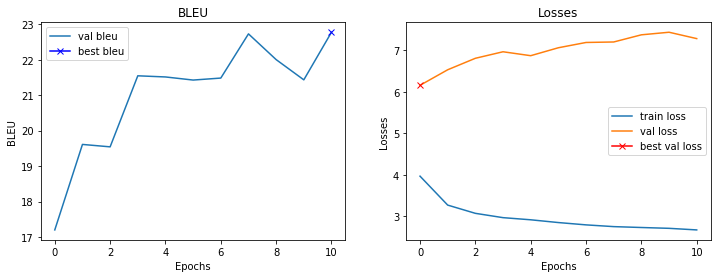

Epoch : 12000
Train example :
	Target: a brown and white dog laying on top of a leopard print pillow .
	Output: a cat and white dog sitting on a of a bed and . .
Random example:
	Target: a man on a skateboard riding on a street .
	Output: a traffic light with a traffic light and a street sign .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding an umbrella over a street .
Train loss    : 2.6493892925977707
Val loss      : 7.55372043159919
Val bleu      : 23.024950304069634



Epoch : 13000
Train example :
	Target: a road at night illuminated with car head lights and street lights
	Output: a view with night with with a lights and . a lights .
Random example:
	Target: a couple of people that are standing in a field
	Output: a cup of coffee sitting on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a hat and a umbrella
Train loss    : 2.6382767345905305
Val loss      : 7.507150339886425
Val bleu      : 22.16284025104136



Epoch : 14000
Train example :
	Target: a closeup of two horses looking right at a camera
	Output: a brown of a brown in a of a fence .
Random example:
	Target: bathroom with tub , toilet , sink , mirror and window .
	Output: a kitchen with a sink , sink , and a window .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while walking down the street .
Train loss    : 2.614449318051338
Val loss      : 7.434312811388879
Val bleu      : 22.610865240540605



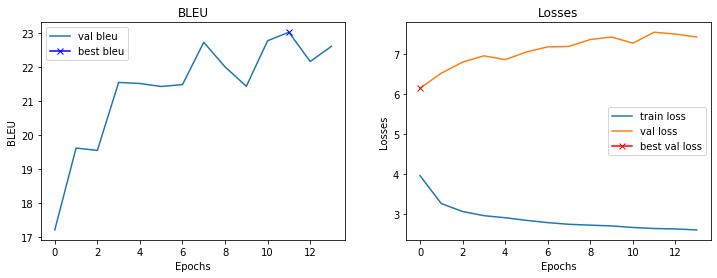

Epoch : 15000
Train example :
	Target: a couple of giraffes walking in the distance
	Output: a white of sheep that across a field .
Random example:
	Target: the man stands in the bathroom with no shirt on brushing his teeth .
	Output: a dog that is laying down in the grass .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.6036821259260177
Val loss      : 7.406079942294899
Val bleu      : 22.954900693802728



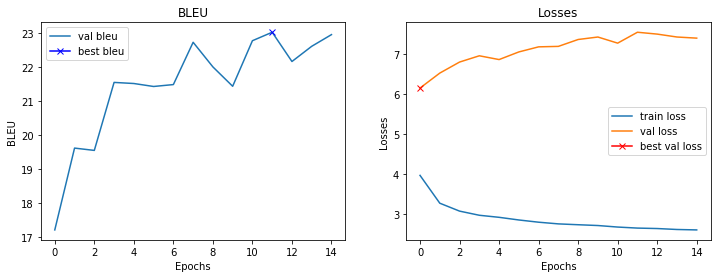

Epoch : 16000
Train example :
	Target: the three women are enjoying a buffet of desserts .
	Output: a table plates are sitting at table of food .
Random example:
	Target: a desk with just a laptop lamp and picture on it .
	Output: a bus parked next to a building with a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella in the rain .
Train loss    : 2.5809733294248582
Val loss      : 7.419519273246207
Val bleu      : 22.928681643946188



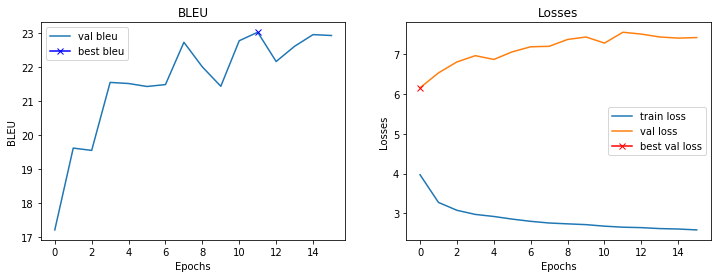

Epoch : 17000
Train example :
	Target: a place setting with various vegetables over UNK on a plate .
	Output: a plate of with a types and it and it table .
Random example:
	Target: a zebra and giraffe stand in a field of grass at a zoo .
	Output: a man and woman are sitting at a table with a dog .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while holding an umbrella .
Train loss    : 2.5539771716594695
Val loss      : 7.478578550705742
Val bleu      : 22.750845831814686



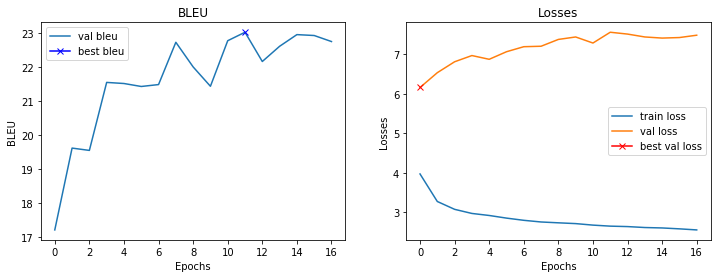

Epoch : 18000
Train example :
	Target: a women is sitting on a subway car with a bottle of water and no shoes .
	Output: a woman who is sitting the couch with . her cat of wine . a her
Random example:
	Target: a grey picnic table with umbrella is placed in front of a row of food trucks .
	Output: a living room with a couch and a table
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding an umbrella while walking down a street .
Train loss    : 2.55862828540802
Val loss      : 7.4947540029923765
Val bleu      : 23.491720713152716



Epoch : 19000
Train example :
	Target: a group of people sitting around a large wooden desk .
	Output: a group of people sitting at a table table table .
Random example:
	Target: a bathroom with a toilet , sink and printed shower curtain
	Output: a bathroom with a toilet and a sink
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.5494777261018755
Val loss      : 7.57045036150511
Val bleu      : 23.40353864262974



Epoch : 20000
Train example :
	Target: a wooden park bench in front of a brick oven .
	Output: a man bench bench in front of a brick wall .
Random example:
	Target: a kitchen with a giant refrigerator freezer next to a table .
	Output: a vase with flowers in it sitting on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while walking down a street .
Train loss    : 2.5263318946361544
Val loss      : 7.6800406864342
Val bleu      : 23.13893598760869



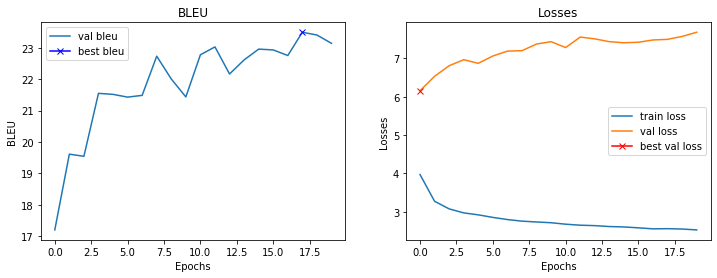

Epoch : 21000
Train example :
	Target: people sitting on the beach with umbrellas blocking out the sun .
	Output: a are sitting the beach with umbrellas . .
Random example:
	Target: a sexy young lady holding a tennis ball and tennis racquet .
	Output: a couple of giraffe standing next to each other in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while walking down the street .
Train loss    : 2.5231475788354873
Val loss      : 7.534880539912195
Val bleu      : 23.820942247341517



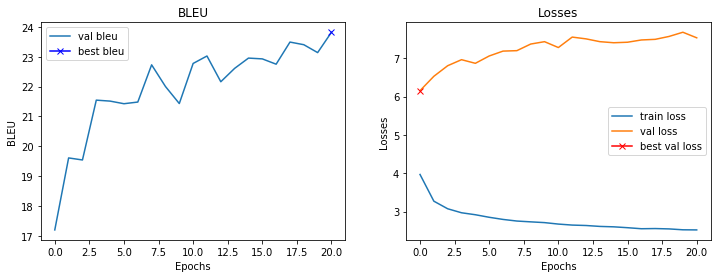

Epoch : 22000
Train example :
	Target: a lady is in the isle of a restaurant with her umbrella up .
	Output: a woman in a a rain chair a chair . a umbrella . .
Random example:
	Target: street signs for w UNK st - UNK UNK way .
	Output: a tall building with a clock on the top .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a hat holding an umbrella .
Train loss    : 2.517998113155365
Val loss      : 7.549813483788715
Val bleu      : 22.53185847527531



Epoch : 23000
Train example :
	Target: a dog and a cat sitting on an unmade bed
	Output: two dog is a dog are on a open bed .
Random example:
	Target: a woman preparing to hit a ball with a racquet .
	Output: a pair of scissors and a ruler on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.4948169966936113
Val loss      : 7.563505100363962
Val bleu      : 23.2442176978731



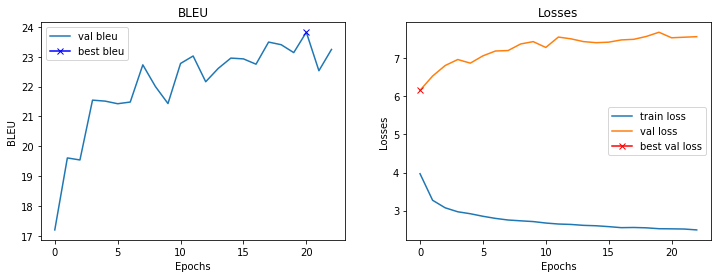

Epoch : 24000
Train example :
	Target: a group of three people holding up smart phones .
	Output: a person of people women holding up a phones .
Random example:
	Target: several kitchen workers making dishes in commercial kitchen .
	Output: a giraffe is standing in a field with a dog .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.4906497436761854
Val loss      : 7.712056630349094
Val bleu      : 22.331235048363308



Epoch : 25000
Train example :
	Target: president obama making a speech for the public .
	Output: a obama obama a speech to a speech speech
Random example:
	Target: a bowl filled with food sitting next to two pieces of bread .
	Output: a man sitting on a bed with a laptop .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a black and white umbrella
Train loss    : 2.485893541574478
Val loss      : 7.693005588965687
Val bleu      : 23.038154307468787



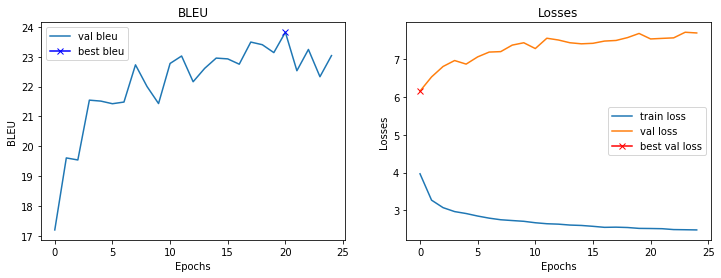

Epoch : 26000
Train example :
	Target: three slices of UNK placed on a cutting board .
	Output: a slices of pizza pizza on a cutting board .
Random example:
	Target: a snow skier is on the white snow .
	Output: a bowl of fruit and a bowl of fruit .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.450332452774048
Val loss      : 7.731296901134295
Val bleu      : 24.34667935884571



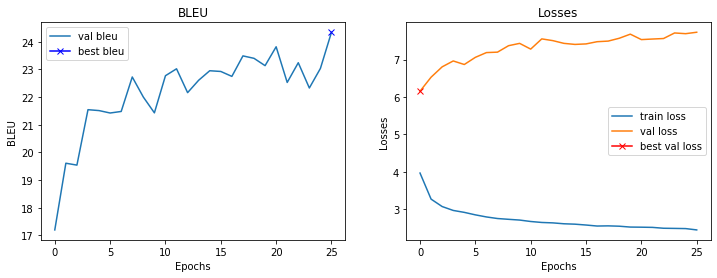

Epoch : 27000
Train example :
	Target: a group of motor cycles and people on horses on a grassy field by a mountain .
	Output: a group of motorcycles riders on a on a . a dirt field . a crowd .
Random example:
	Target: an open laptop computer sitting on top of a wooden desk .
	Output: a pizza sitting on top of a white plate .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing on a street .
Train loss    : 2.443842609167099
Val loss      : 7.718067931612009
Val bleu      : 23.60182338577391



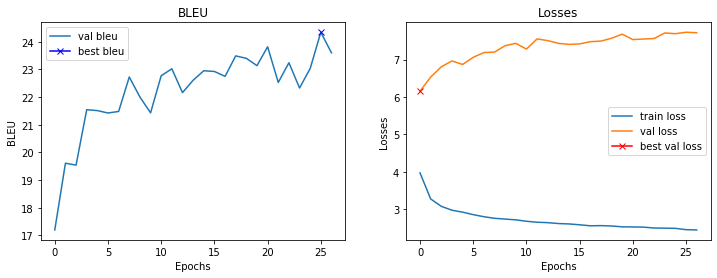

Epoch : 28000
Train example :
	Target: a large jetliner landing on a runway at an airport .
	Output: a large plane sitting on a runway with an airport .
Random example:
	Target: a little boy that is sitting inside of a plane
	Output: a zebra is standing in a fenced in area .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.4369175745248794
Val loss      : 7.627600678906531
Val bleu      : 23.336249999162913



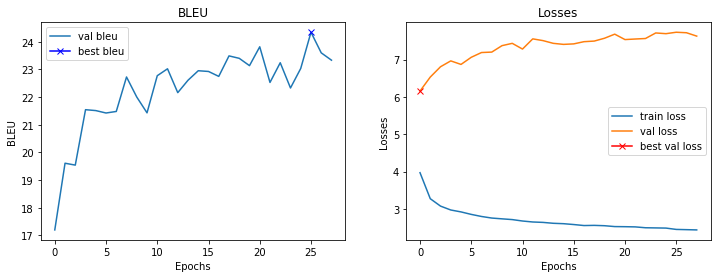

Epoch : 29000
Train example :
	Target: a young boy holding a baseball bat while standing on a baseball field .
	Output: a baseball boy is a bat on on standing on a field field .
Random example:
	Target: there is a male skier riding down a snow hill
	Output: a woman in a blue dress playing tennis
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a blue shirt holding an umbrella .
Train loss    : 2.4207711801528933
Val loss      : 7.700044462674356
Val bleu      : 23.92409277858894



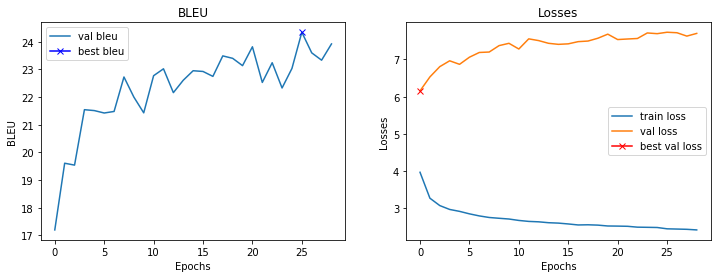

Epoch : 30000
Train example :
	Target: two people riding a motor bike near some buses .
	Output: a people on a red bike on a buildings
Random example:
	Target: driving on a highway behind a compact car , on the way to nice
	Output: a man in a tie and tie standing in a room .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.420543704152107
Val loss      : 7.552895704905192
Val bleu      : 23.94924806261591



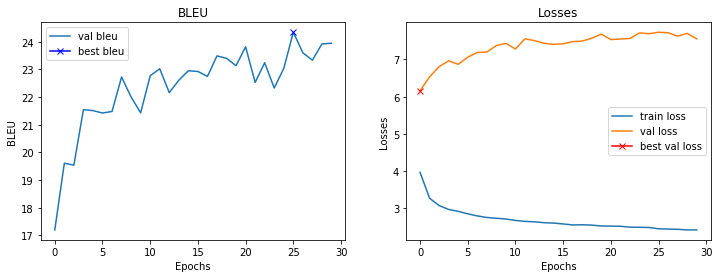

Epoch : 31000
Train example :
	Target: a man is working at a red clothed table
	Output: a man and woman on a table with woman . a . . . . . . . .
Random example:
	Target: a small dog on top of a skateboard .
	Output: a living room with a couch , tv , and a tv .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.4223362826108934
Val loss      : 7.61771450456242
Val bleu      : 24.326907846983296



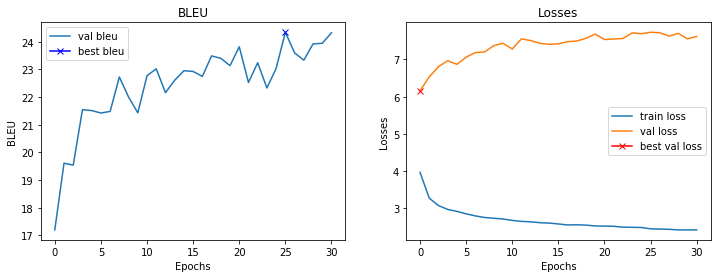

Epoch : 32000
Train example :
	Target: a man riding a snowboard down a mountain covered in snow .
	Output: a person riding skis snowboard down a snow slope slope snow .
Random example:
	Target: a young man holding a bunch of green bananas inside of a store .
	Output: a man throwing a frisbee in a park .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a black coat and a black umbrella
Train loss    : 2.38751874089241
Val loss      : 7.780697036887895
Val bleu      : 24.251005622448556



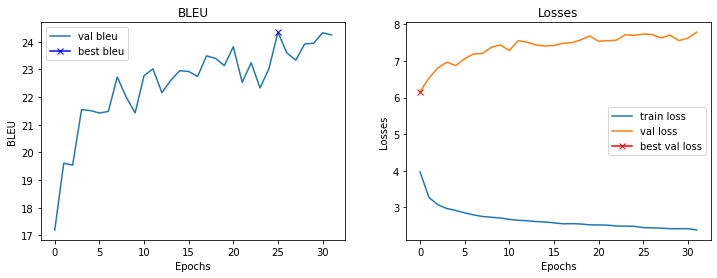

Epoch : 33000
Train example :
	Target: a large locomotive engine traveling down a graffiti covered wall .
	Output: a train is is traveling down the track . . .
Random example:
	Target: a man sitting at a table eating a hot dog .
	Output: a woman in a pink dress is playing tennis
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.383217936038971
Val loss      : 7.8519835588408675
Val bleu      : 24.43633809121548



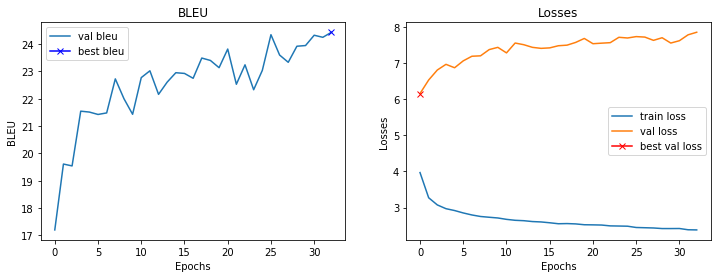

Epoch : 34000
Train example :
	Target: people standing on a platform next to a train .
	Output: a are on a platform waiting to a train .
Random example:
	Target: a group of people riding horses on top of a beach .
	Output: a group of people riding motorcycles down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.3873112459182737
Val loss      : 7.852813092673697
Val bleu      : 24.165062295469756



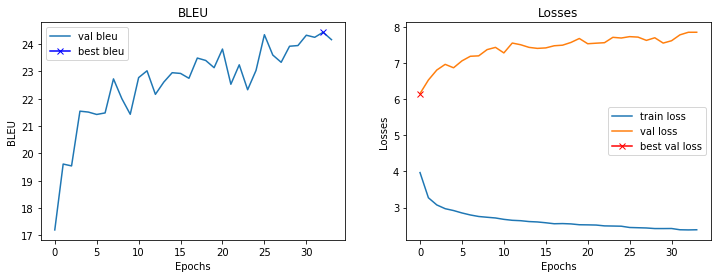

Epoch : 35000
Train example :
	Target: a white double decker bus parked by the curb
	Output: a double bus decker bus parked next a curb .
Random example:
	Target: a bowl of very fresh , chopped UNK ingredients .
	Output: a kitchen with a sink , a sink and a mirror .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.3910814048051834
Val loss      : 7.808414945111365
Val bleu      : 23.932349221374814



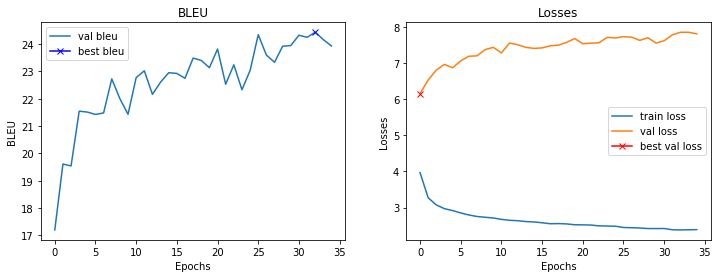

Epoch : 36000
Train example :
	Target: a bench in need of repair on the sidewalk .
	Output: a wooden with a a piece and it side .
Random example:
	Target: there is a giraffe standing alone on a field
	Output: a man riding a skateboard down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella and a woman in the background .
Train loss    : 2.3938261474370957
Val loss      : 7.734106498035958
Val bleu      : 24.12376383604603



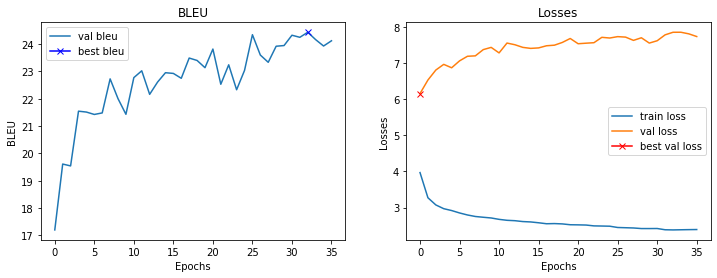

Epoch : 37000
Train example :
	Target: church like building with four clocks located on the sides of it's roof tower
	Output: a with a with a windows on on the sides of it tower . .
Random example:
	Target: a bowl filled with granola and banana slices .
	Output: a group of people on skis standing in the snow .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.3860260347127915
Val loss      : 7.8130709640378875
Val bleu      : 24.21950526844621



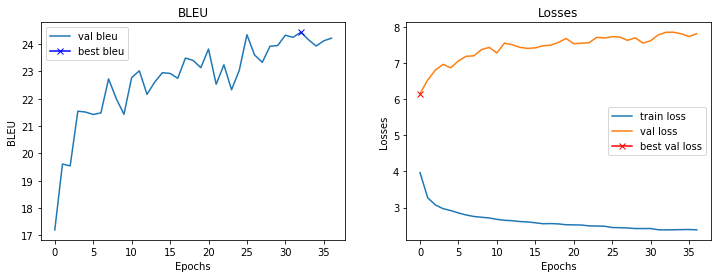

Epoch : 38000
Train example :
	Target: two small birds on a bench with a blurry background
	Output: a birds birds are a tree in a bird background .
Random example:
	Target: a policeman roller boarding in the street with another man .
	Output: a man sitting on a bench in front of a tv .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.3810778971910476
Val loss      : 7.883680127823579
Val bleu      : 23.824843613961324



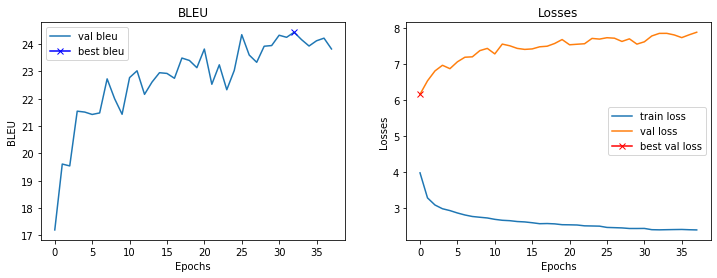

Epoch : 39000
Train example :
	Target: a man holding out a fork with some food on it
	Output: a hand is a a small with a food . it
Random example:
	Target: someone is holding up a spotted banana with the end torn off .
	Output: a truck is parked next to a large truck .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.368941910147667
Val loss      : 7.90350701298494
Val bleu      : 24.1196793524652



Epoch : 40000
Train example :
	Target: laptop computer next to a radiator on a desk .
	Output: a computer sitting to a lamp with a desk .
Random example:
	Target: a close up of two zebras near one another near trees
	Output: a refrigerator with a refrigerator and a refrigerator .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.3543720048666
Val loss      : 7.836274631624299
Val bleu      : 24.244514834008953



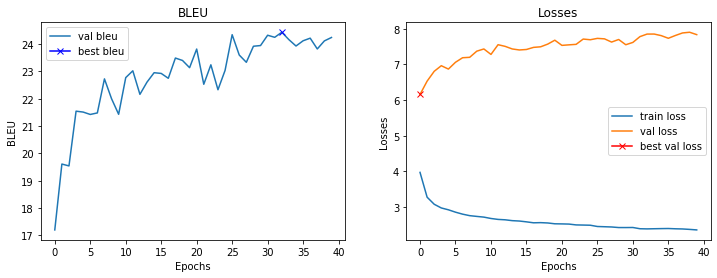

Epoch : 41000
Train example :
	Target: a giraffe is standing in a grassy field
	Output: a giraffe standing standing in a field field .
Random example:
	Target: a kitchen with tile floor and carpeted room in the background .
	Output: a clock tower with a clock on the top of it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a black shirt and a black umbrella
Train loss    : 2.3597092176675796
Val loss      : 7.891762907912091
Val bleu      : 23.757409738019117



Epoch : 42000
Train example :
	Target: a man in the progress of getting ready for a wedding .
	Output: a man in a suit of a a to a man .
Random example:
	Target: a dog in the water with a bottle in its mouth .
	Output: a woman walking down a street holding an umbrella .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.3656675658226014
Val loss      : 7.958123620609604
Val bleu      : 24.286624558473076



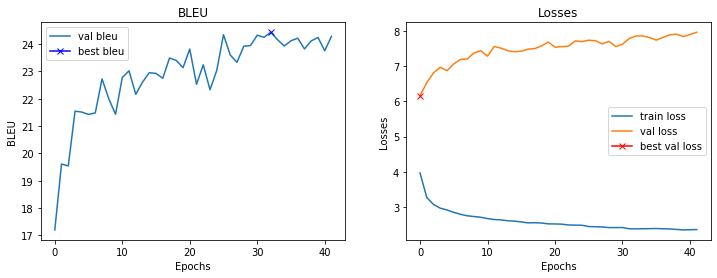

Epoch : 43000
Train example :
	Target: a man surrounded by surf boards sitting on the beach
	Output: a man sitting by surfboards boards on on a beach . a surfboards .
Random example:
	Target: a grocery store display filled with lots of apples .
	Output: a train is pulling into a station station .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.367177417755127
Val loss      : 7.925019334002239
Val bleu      : 24.1752486357239



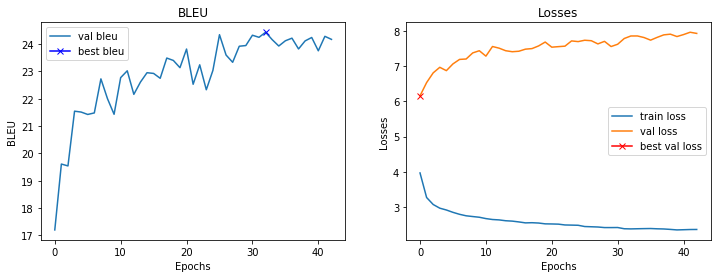

Epoch : 44000
Train example :
	Target: a boy is dressed up in a tie and is holding a stick .
	Output: a young is holding in in a forest and a holding a teddy .
Random example:
	Target: a large white teddy bear sitting in a wooden electric chair .
	Output: a fire hydrant on the side of the road .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.3530401045084
Val loss      : 7.839448649708817
Val bleu      : 23.999129817408235



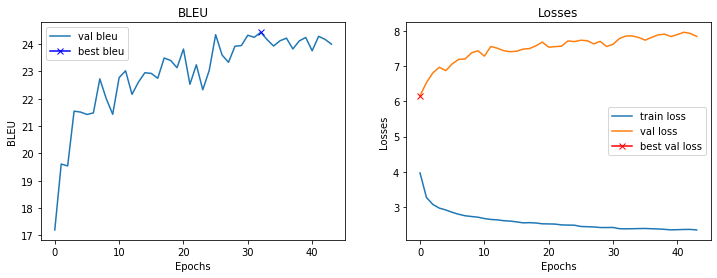

Epoch : 45000
Train example :
	Target: three cellphones are sitting chained to a table .
	Output: a cellphones are sitting on to each pole .
Random example:
	Target: a fruit basket with oranges , pears , an UNK fruit .
	Output: a pair of scissors and a pair of scissors .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.3482206584215164
Val loss      : 7.874020160375249
Val bleu      : 24.402039727383748



Epoch : 46000
Train example :
	Target: a woman holding a frisbee walking on an ocean beach .
	Output: a man standing a surfboard on on a beach beach .
Random example:
	Target: a lady standing next to a person with a umbrella
	Output: a man is riding a horse in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.336891993880272
Val loss      : 7.956036841643212
Val bleu      : 24.134833284090657



Epoch : 47000
Train example :
	Target: a man holding a stop sign in the street .
	Output: a man in a red sign and the street .
Random example:
	Target: a man riding a skateboard around white cones .
	Output: a man standing in front of a laptop computer .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a red umbrella in a field .
Train loss    : 2.341347952246666
Val loss      : 7.993693465462868
Val bleu      : 24.13047476303671



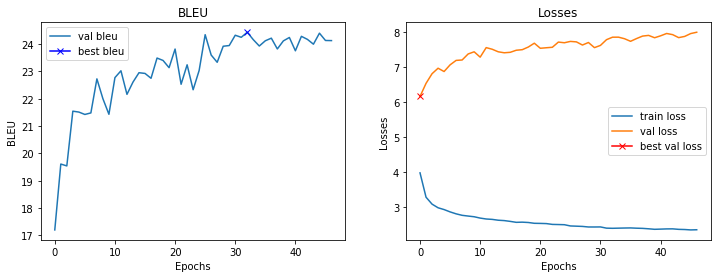

Epoch : 48000
Train example :
	Target: a man standing on top of his head while riding a skateboard .
	Output: a man holding a to of a head on holding a skateboard .
Random example:
	Target: a man riding a skateboard on the side of a cement block .
	Output: a truck with a broken bed and a truck .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.3318478198051453
Val loss      : 7.971777910785623
Val bleu      : 24.08397153549938



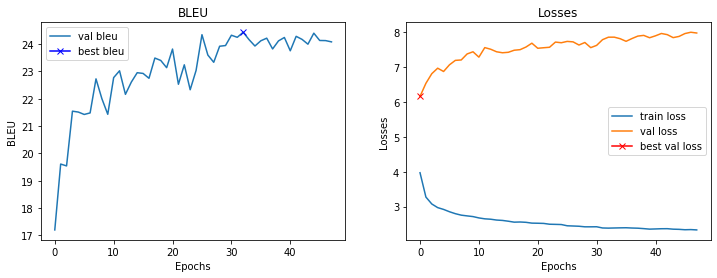

Epoch : 49000
Train example :
	Target: some horses grazing in an open field of tall grass .
	Output: a horses grazing in a open field
Random example:
	Target: an image of man doing tricks on a skateboard
	Output: a group of vegetables and vegetables on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.3357395414114
Val loss      : 8.076631844528322
Val bleu      : 24.175846787127757



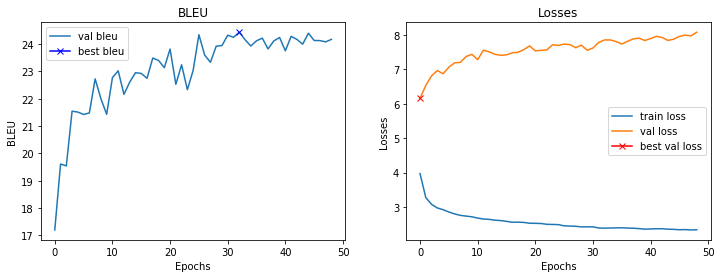

Epoch : 50000
Train example :
	Target: a man is holding up a baby while he is in the kitchen
	Output: a man and woman a woman cake in a is in a kitchen .
Random example:
	Target: a small boat is going down the river in front of colorful trees .
	Output: a street with a stop sign and a street sign .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.33243324303627
Val loss      : 8.058235846883882
Val bleu      : 24.24898770197749



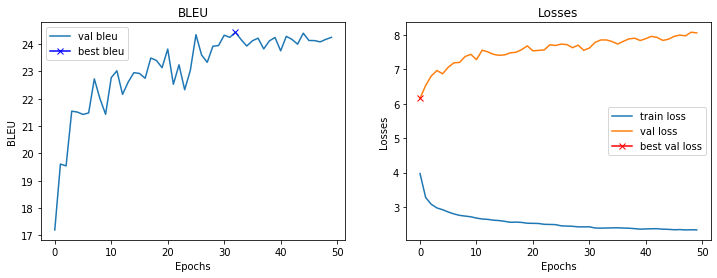

Epoch : 51000
Train example :
	Target: three people and a black car are dressed in ski jackets and two are wearing skis and our out in the snow while the third person is off to the side with her snowboard .
	Output: a people are a child ski are on in snow gear . a people standing skis . snowboards snow the the snow . others other skier is standing the the side . one skis .
Random example:
	Target: a group of people standing on top of a building near a large clock .
	Output: a city street with a lot of cars parked on the side of the road .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3189710627794264
Val loss      : 7.952528130394334
Val bleu      : 24.05969465032505



Epoch : 52000
Train example :
	Target: a white toilet sitting next to a bath tub .
	Output: a bathroom toilet sitting next to a shower tub .
Random example:
	Target: a large white bed with a wooden headboard .
	Output: a man riding a motorcycle down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a colorful umbrella in a field .
Train loss    : 2.3144277472496033
Val loss      : 7.9690726882397
Val bleu      : 24.645025456245456



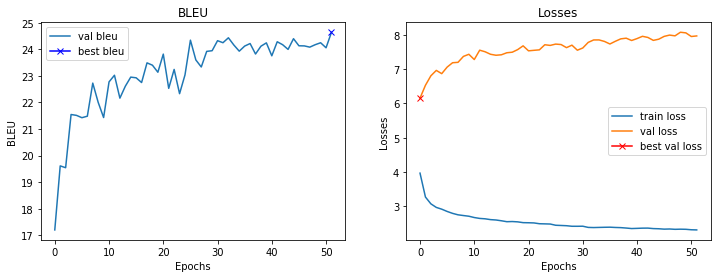

Epoch : 53000
Train example :
	Target: there is a boat on the side of an island
	Output: a is a boat boat the water of the water
Random example:
	Target: ornate clock on face of large block building .
	Output: a cat sitting on a desk next to a laptop .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.299287817358971
Val loss      : 7.800768706210584
Val bleu      : 24.567559889784672



Epoch : 54000
Train example :
	Target: three men admiring motorcycles in a sidewalk exhibit .
	Output: a people are at in a city next .
Random example:
	Target: a person wearing skis holding their arms wide open on a snow covered slope .
	Output: a man is sitting on a bench in the grass .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.3099722889661787
Val loss      : 7.858256685055368
Val bleu      : 24.28652701978031



Epoch : 55000
Train example :
	Target: a couple people at the beach working on an object that looks like large wings .
	Output: a man of sitting a beach with on a kite . is like a elephant .
Random example:
	Target: a ca standing next to a woman wearing a cat shoe .
	Output: a giraffe is standing in a field with a fence .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.308102518796921
Val loss      : 7.946376411572381
Val bleu      : 24.529459100088268



Epoch : 56000
Train example :
	Target: two skiers wait on an embankment of snow on the edge of a ski course .
	Output: a people are to a obstacle on a . a snow of a mountain slope .
Random example:
	Target: a man wearing an umbrella hat at a park
	Output: a man holding a kite in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.3073651075363157
Val loss      : 7.941128962085176
Val bleu      : 24.991090480337792



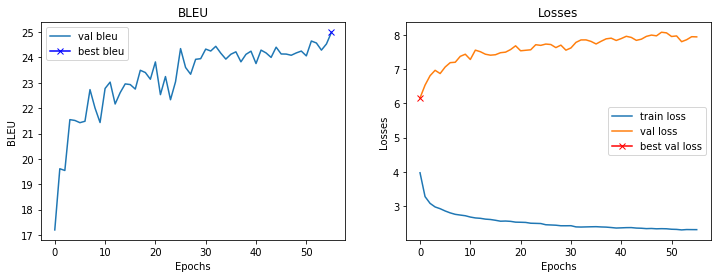

Epoch : 57000
Train example :
	Target: there are four giraffes standing among some dry brush
	Output: a are giraffes giraffes standing in the trees brush
Random example:
	Target: an adult zebra stands with its young in a field .
	Output: a banana and a banana on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.2815127489566804
Val loss      : 7.919907386386944
Val bleu      : 24.57493008474283



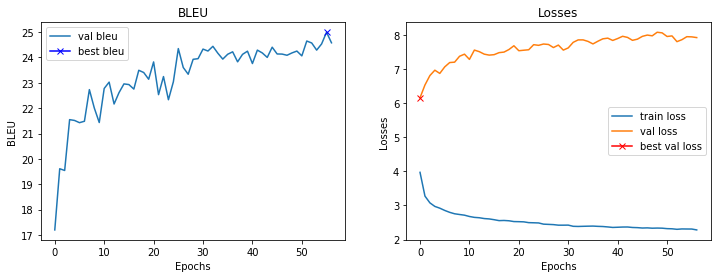

Epoch : 58000
Train example :
	Target: train waiting to board in the UNK train station
	Output: a tracks at board at a train of station .
Random example:
	Target: donuts are being made in a factory .
	Output: a glass vase with a candle on it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.3106138924360273
Val loss      : 7.766596012322237
Val bleu      : 24.56727957947123



Epoch : 59000
Train example :
	Target: three men in nice clothing talking to each other .
	Output: a men in suits clothing standing to each other .
Random example:
	Target: a plate of food sits on a plane table .
	Output: a man is sitting at a table with wine glasses .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.2940953348875044
Val loss      : 7.878849828146337
Val bleu      : 24.473504768801728



Epoch : 60000
Train example :
	Target: a child jumping up to catch a frisbee .
	Output: a young is a to catch a frisbee .
Random example:
	Target: two cats laying on a couch and sleeping .
	Output: a man and a woman are sitting on a bench .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella and a woman in the rain .
Train loss    : 2.2917660931348802
Val loss      : 7.971720845395634
Val bleu      : 24.779740659768187



Epoch : 61000
Train example :
	Target: a sign at a street corner of east UNK st and park ave with a one way sign on top .
	Output: a street that the intersection corner with east st ave . UNK ave .
Random example:
	Target: one man throws a UNK to another man at a park .
	Output: a group of people sitting at a table with food .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.296584400057793
Val loss      : 7.9239445779381725
Val bleu      : 24.98995506491986



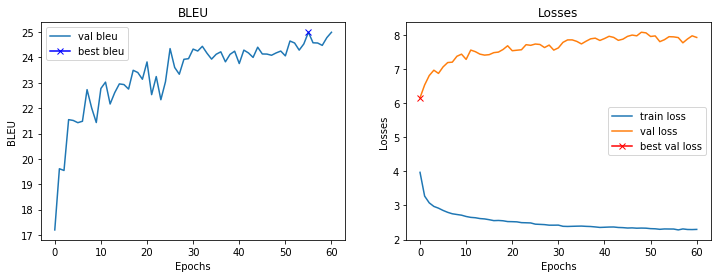

Epoch : 62000
Train example :
	Target: a brown table with some plates of food and bottles and glasses
	Output: a table table topped a bottles and food and a of wine
Random example:
	Target: a slice of pizza partially UNK a cell phone .
	Output: a group of three vases sitting on top of a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.309517287969589
Val loss      : 7.897470985970846
Val bleu      : 24.871692651567706



Epoch : 63000
Train example :
	Target: a green street sign mounted to a traffic light .
	Output: a street street sign with to a pole . .
Random example:
	Target: an image of a woman is oddly colored .
	Output: a cat is laying on a couch with a remote .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.302516343951225
Val loss      : 7.944079238870926
Val bleu      : 24.810431320638358



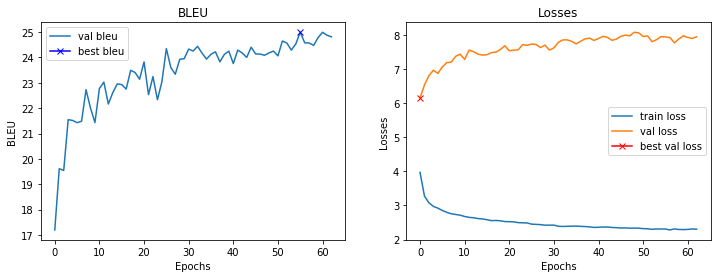

Epoch : 64000
Train example :
	Target: a group of livestock are grazing in bright green grass .
	Output: a group of people grazing grazing in the green grass .
Random example:
	Target: an older man standing next to a garage and a young boy .
	Output: a man in a suit and tie standing in front of a window .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in a field .
Train loss    : 2.279004474043846
Val loss      : 7.947007623791372
Val bleu      : 24.7513991789998



Epoch : 65000
Train example :
	Target: someone is juicing an orange on a juicer .
	Output: a juicing juicing a interesting juicing in knife .
Random example:
	Target: a luggage cart stacked with a very tall pile of luggage .
	Output: a table with a variety of fruits and vegetables .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a black shirt and a black umbrella
Train loss    : 2.2757348728179934
Val loss      : 7.990135806685863
Val bleu      : 24.760332269255322



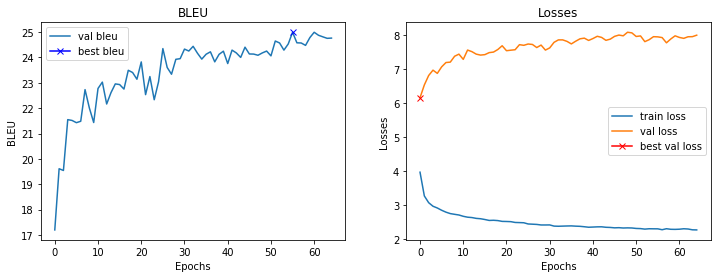

Epoch : 66000
Train example :
	Target: a bathroom is decorated in bright blue marble designs .
	Output: a bathroom with decorated with a colors and white .
Random example:
	Target: a young boy UNK a parachute near some water .
	Output: a group of people riding horses on a beach .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding a colorful umbrella in a field .
Train loss    : 2.2801272423267362
Val loss      : 7.909145109698701
Val bleu      : 24.553677984006665



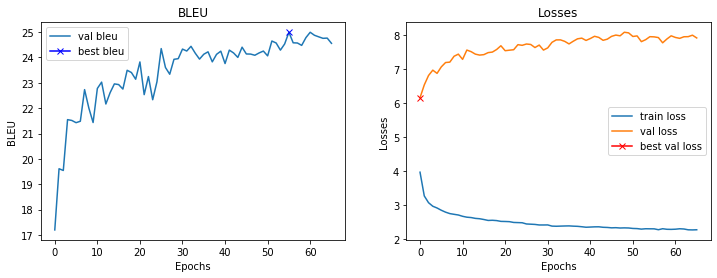

Epoch : 67000
Train example :
	Target: a black and while motorcycle with a dog in a side car .
	Output: a black and white a parked a black and the sidecar of .
Random example:
	Target: a woman standing over a pile of vegetables under hanging banana .
	Output: a bed with a wooden frame and a wooden frame .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.2847378603219988
Val loss      : 7.900218070684087
Val bleu      : 24.566515453977335



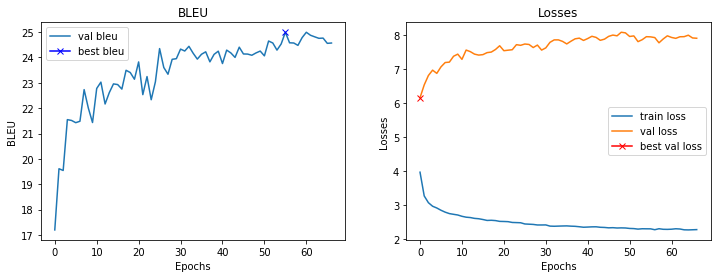

Epoch : 68000
Train example :
	Target: two people in dark holding up open umbrellas under archway to wet UNK courtyard .
	Output: a group walking a suits umbrellas umbrellas umbrellas .
Random example:
	Target: father holding child while elephant stands in front of them .
	Output: a cat is sitting on a piece of luggage .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a red shirt and a black umbrella
Train loss    : 2.2921068162918092
Val loss      : 7.90874362573391
Val bleu      : 24.93261783114783



Epoch : 69000
Train example :
	Target: a man carrying a surfboard on top of a sandy beach .
	Output: a man on a surfboard in a of a wave beach .
Random example:
	Target: the child in the red coat is running through the snow near a kite .
	Output: a little girl standing in front of a window holding a wii remote .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in a field .
Train loss    : 2.2758951632976534
Val loss      : 8.072148215803027
Val bleu      : 25.077654246070946



Epoch : 70000
Train example :
	Target: a tall brick building behind a tall water fountain .
	Output: a fire brick building with a brick white . .
Random example:
	Target: a pretty green apple sitting on some oranges .
	Output: a vase with flowers in it sitting on a table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.270761560797691
Val loss      : 7.930571035317935
Val bleu      : 24.906394329592317



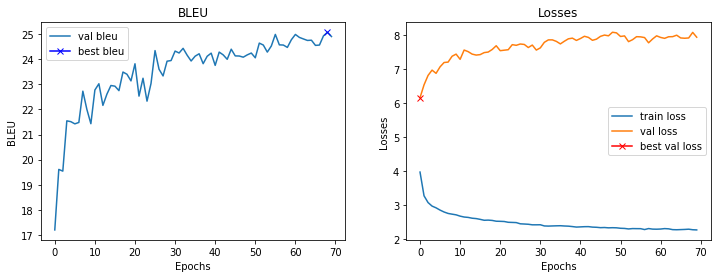

Epoch : 71000
Train example :
	Target: a person that is standing by a train .
	Output: a bed is is looking near a window .
Random example:
	Target: a tv remote control sits on a table .
	Output: a table with a pizza and a glass of beer .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man and a woman holding an umbrella .
Train loss    : 2.272570982217789
Val loss      : 7.882954097375637
Val bleu      : 24.54363729824022



Epoch : 72000
Train example :
	Target: looking through a rear view mirror are trees and a one way traffic sign .
	Output: a down the street mirror mirror of reflecting and a parking way sign sign .
Random example:
	Target: a sliced sandwich with a pickle on a plate .
	Output: a train is on the tracks near a platform .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the rain .
Train loss    : 2.261498100399971
Val loss      : 8.134807197705195
Val bleu      : 24.639412192064547



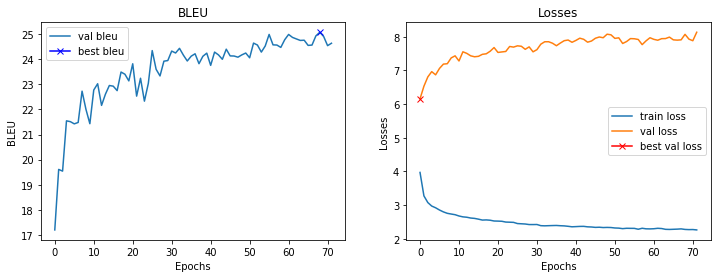

Epoch : 73000
Train example :
	Target: two males in uniforms are cutting a cake and plates
	Output: a sailors in military are cutting a cake . celebrating .
Random example:
	Target: a large brown dog holding a soccer ball .
	Output: a man is on a boat in the water .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the rain .
Train loss    : 2.273432230114937
Val loss      : 8.092924695673997
Val bleu      : 24.59524885897873



Epoch : 74000
Train example :
	Target: a vase filled with green leafed flowers on a window sill .
	Output: a vase with with flowers leafed flowers on a table sill .
Random example:
	Target: a restaurant kitchen under construction in a building .
	Output: a man is a laptop computer in a room .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella in the rain .
Train loss    : 2.2681800332069395
Val loss      : 7.98628877107367
Val bleu      : 24.61192103576608



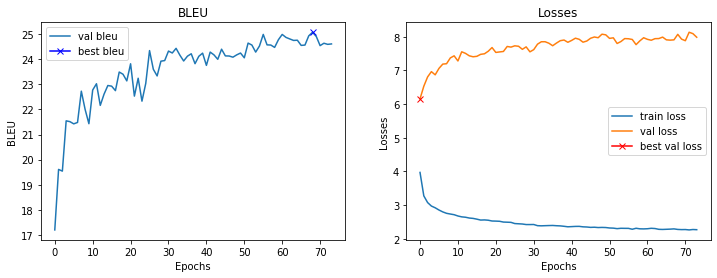

Epoch : 75000
Train example :
	Target: group of bikers posing for a picture
	Output: a of people in for a picture with a . . . . . . . .
Random example:
	Target: a building with a steep sloping roof and five windows .
	Output: a clock tower with a clock on the top of it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding a colorful umbrella in the rain .
Train loss    : 2.268847090005875
Val loss      : 7.963513663790736
Val bleu      : 24.571689227482384



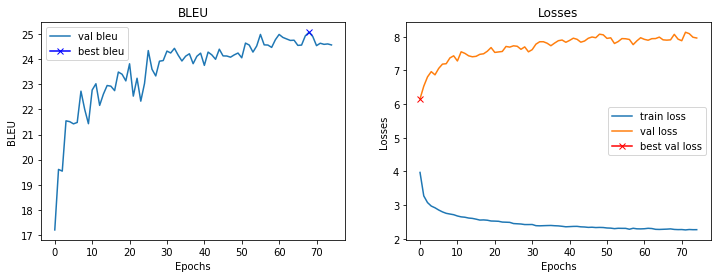

CPU times: user 1h 37min 9s, sys: 35min 39s, total: 2h 12min 48s
Wall time: 2h 13min 59s


In [0]:
%%time
best_bleu = 0
epoch_loss = 0
train_losses = []
val_losses = []
bleu = []
tf = 0.9

for epoch in range(1, max_epochs+1):

  image_vectors, captions_ix = generate_batch(train_img_codes, train_captions, batch_size)
  image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

  captions_ix_next = captions_ix[:, 1:].contiguous()

  network.train()

  optimizer.zero_grad()
        
  outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=tf)
  
  loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
        
  loss.backward()
        
  torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
        
  optimizer.step()

  scheduler.step()
        
  epoch_loss += loss.item()

  if epoch % every_epochs == 0:
    # Выводим произвольный пример для train dataset
    print('Epoch : {}'.format(epoch))
    print('Train example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))
    # Валидируемся
    val_loss, val_bleu = evaluate(network, criterion)   
    print('Train loss    : {}'.format(epoch_loss / every_epochs))
    print('Val loss      : {}'.format(val_loss))
    print('Val bleu      : {}'.format(val_bleu))
    print()
    # Запоминаем новые значения для графиков
    train_losses.append(epoch_loss / every_epochs)
    val_losses.append(val_loss)
    bleu.append(val_bleu)
    # Сохраняем модель с лучшим BLEU
    if val_bleu > best_bleu:
      best_bleu = val_bleu
      torch.save(network.state_dict(), '/content/gdrive/My Drive/Image Captioning/model_best_bleu.pt')
    epoch_loss = 0
    # Рисуем графики
    plot_loss()

In [0]:
best_bleu

25.077654246070946

In [0]:
# Сохраняем веса с последней эпохи
torch.save(network.state_dict(), '/content/gdrive/My Drive/Image Captioning/model_75_epoch.pt')

# Inseption и получение результатов


Перед подачей в нашу модель произвольных картинок, их необходимо предварительно прогнать через Inception v3.

In [0]:
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url

In [0]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048

        return x_for_attn, x_for_capt 

In [0]:
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [0]:
%%time
inception = beheaded_inception_v3().train(False)

CPU times: user 4min, sys: 552 ms, total: 4min 1s
Wall time: 4min 2s


Напишем функции, которые будут помогать строить описания произвольных картинок. Описания будем генерировать разными способами:


1.   **Argmax** (брать на каждом шаге наиболее вероятное слово)
2.   **Sample** (брать на каждом шаге слово в соответствии с полученными вероятностями)
3.   **Beam search** (на каждом шаге рассматривать k наиболее вероятных вариантов)



In [0]:
def generate_captions(image, num_samples=5, max_len=100, top_k=3, t=1.):

    plt.imshow(img)
    plt.show()

    print('argmax:')
    print()
    generate_caption(img, max_len=max_len)
    print()

    print('samples:')
    print()
    for i in range(num_samples):
        generate_caption(img, mode='sample', max_len=max_len, t=t)
    print()

    print('beam search:')
    print()
    generate_caption(img, mode='beam search', max_len=max_len, top_k=top_k)

In [0]:
def generate_caption(image, mode='argmax', max_len=100, top_k=3, t=1):
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    network.eval()

    with torch.no_grad():

        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0)

        vectors_8x8, vectors_neck = inception(image)

        if mode == 'sample':
            print(network.sample(vectors_neck.to(device), max_len, st=t))
        elif mode == 'beam search':
            seq, seqs = network.beam_search(vectors_neck.to(device), top_k=top_k, max_len=max_len)
            print(translate(seq))
            print()
            print('top {}'.format(top_k))
            print()
            for s in seqs:
              print(translate(s))
        else:
            outputs = network(vectors_neck.to(device), teacher_forcing_ratio=0.)

            print(translate(outputs.argmax(-1)[0].tolist()))

## Последняя модель

Скачаем пару картинок, чтобы проверить качество генерации на модели с последней эпохи:

In [0]:
# network.load_state_dict(torch.load('/content/gdrive/My Drive/Image Captioning/v2_model_75_epoch.pt'))

<All keys matched successfully>

In [0]:
# network.eval()
# network = network.to(device)

2020-02-21 02:56:03 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


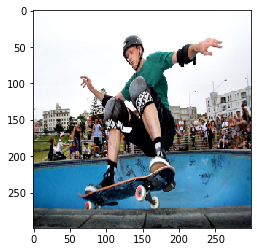

argmax:

a man is doing a trick on a skateboard .

samples:

a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard up the side of a ramp .
a man is doing a trick on a skateboard .
a man on a skateboard is performing a trick .

beam search:

a man riding a skateboard on top of a ramp .

top 3

a man riding a skateboard up a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard up the side of a ramp .


In [0]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, t=5, top_k=3)

In [0]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=3)

2020-02-21 02:58:21 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


argmax:

a cat sitting on a couch with a stuffed animal .

samples:

a large dog is lying on a couch
a cat sitting on a couch with a stuffed toy .
a black and white cat sitting on a of a couch .
a black and white cat is staring at the camera
a small dog sitting on a couch with a stuffed animal .

beam search:

a black and white cat sitting on a couch .

top 3

a black and white cat laying on a couch .
a black and white cat sitting on a couch .
a black and white cat laying on top of a couch .


А теперь еще несколько примеров:

2020-02-21 02:58:43 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev [12239/12239] -> "img.jpg" [1]


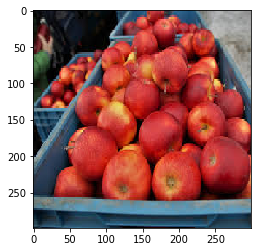

argmax:

a crate filled with lots of apples and oranges .

samples:

a basket filled with lots of apples and oranges .
a bunch of apples that are on a table
a basket filled with apples and oranges on a table .
a crate filled with lots of apples and apples .
a bunch of apples in a basket with a crate of oranges .

beam search:

a crate filled with lots of apples and oranges .

top 3

a crate filled with lots of apples and oranges .
a bunch of apples that are sitting on a table .
a bunch of apples that are sitting in a bin .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

Протестируем различные значения для beam search.

Для 1 получаем уже знакомый argmax:

In [0]:
generate_caption(img, mode='beam search', top_k=1)

a crate filled with lots of apples and oranges .

top 1

a crate filled with lots of apples and oranges .


In [0]:
generate_caption(img, mode='beam search', top_k=2)

a crate filled with lots of apples and oranges .

top 2

a crate filled with lots of apples and oranges .
a crate filled with lots of apples sitting on top of a table .


In [0]:
generate_caption(img, mode='beam search', top_k=3)

a crate filled with lots of apples and oranges .

top 3

a crate filled with lots of apples and oranges .
a bunch of apples that are sitting on a table .
a bunch of apples that are sitting in a bin .


In [0]:
generate_caption(img, mode='beam search', top_k=4)

a crate filled with lots of apples and apples .

top 4

a crate filled with lots of apples and oranges .
a crate filled with lots of apples and apples .
a bunch of apples that are sitting on a table .
a bunch of apples that are sitting in a bin .


In [0]:
generate_caption(img, mode='beam search', top_k=5)

a crate filled with lots of apples and apples .

top 5

a bunch of apples that are on a table
a crate filled with lots of apples and oranges .
a crate filled with lots of apples and apples .
a bunch of apples that are sitting on a table .
a bunch of apples that are sitting in a bin .


In [0]:
generate_caption(img, mode='beam search', top_k=6)

a pile of apples sitting on top of a table .

top 6

a crate filled with lots of apples and oranges .
a crate filled with lots of apples and apples .
a bunch of apples that are sitting on a table .
a pile of apples sitting on top of a table .
a bunch of apples that are sitting in a bin .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=7)

a pile of apples sitting on top of a table .

top 7

a crate filled with lots of apples and oranges .
a crate filled with lots of apples and apples .
a crate filled with lots of different types of apples .
a bunch of apples that are sitting on a table .
a pile of apples sitting on top of a table .
a bunch of apples that are sitting in a bin .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=8)

a bin filled with lots of apples and oranges .

top 8

a crate filled with lots of apples and oranges .
a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a bin filled with lots of different types of apples .
a bunch of apples that are sitting on a table .
a pile of apples sitting on top of a table .
a bunch of apples that are sitting in a bin .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=9)

a bunch of apples that are sitting on a table .

top 9

a crate filled with lots of apples and oranges .
a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a bin filled with lots of different types of apples .
a crate filled with lots of different types of apples .
a bunch of apples that are sitting on a table .
a pile of apples sitting on top of a table .
a bunch of apples that are sitting in a bin .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=10)

a bunch of apples that are sitting on a table .

top 10

a crate filled with lots of apples and oranges .
a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a crate filled with lots of apples and apples .
a bin filled with lots of different types of apples .
a crate filled with lots of different types of apples .
a bunch of apples that are sitting on a table .
a pile of apples sitting on top of a table .
a bunch of apples that are sitting in a bin .
a pile of apples sitting on top of a wooden table .


2020-02-21 02:59:59 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k [9632/9632] -> "img.jpg" [1]


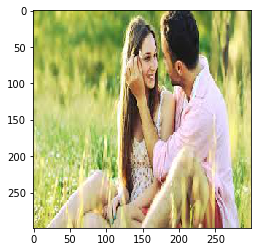

argmax:

a woman and a baby sitting on a bench .

samples:

a woman sitting on a bench with a baby .
a woman sitting on a bench with her dog .
a woman and a woman sitting on a bench .
a woman and a young boy sitting on a bench .
a woman sitting on a bench with a baby .

beam search:

a woman and a young girl sitting on a bed .

top 3

a woman and a young girl sitting on a bench .
a woman and a young girl sitting on a bed .
a woman and a young girl sitting on top of a bed .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 03:00:32 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 [11513/11513] -> "img.jpg" [1]


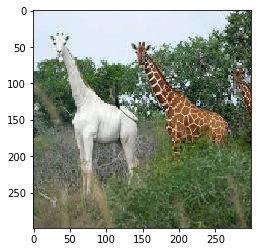

argmax:

a giraffe standing in the grass with a tree in the background .

samples:

a giraffe standing in a field with a fence .
a giraffe standing in the middle of a field .
a white horse standing in a field of grass .
a giraffe standing in a field of grass .
a giraffe standing next to a tree in the grass .

beam search:

a couple of giraffe standing next to each other .

top 3

a couple of giraffe standing next to each other .
a couple of giraffe standing next to each other in a field .
a couple of giraffe standing next to each other on a lush green field .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 03:01:05 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB [14304/14304] -> "img.jpg" [1]


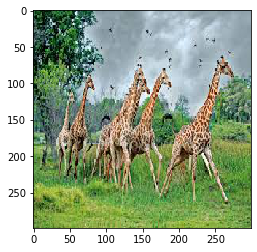

argmax:

a group of giraffes standing in a field .

samples:

a group of giraffes standing in a field .
a group of giraffes standing around a field .
a group of giraffes standing in a field .
a group of giraffes standing in a field .
a group of giraffes walking across a grass field .

beam search:

a group of giraffe standing next to each other .

top 3

a group of giraffe standing next to each other .
a group of giraffe standing next to each other on a field .
a group of giraffe standing next to each other in a field .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 03:01:43 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl [12524/12524] -> "img.jpg" [1]


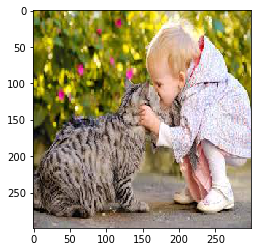

argmax:

a woman is holding a baby sheep in a field .

samples:

a woman is holding a baby sheep in a field .
a woman sitting on a bench with a dog .
a woman holding a cat in her lap
a woman is holding a cat in her arms .
a woman holding a baby sheep in a field .

beam search:

a woman in a gray sweater holding a sheep .

top 5

a woman in a gray sweater holding a sheep
a woman is holding a sheep in her hand
a woman is holding a cat in her lap .
a woman is holding a sheep in her hand .
a woman in a gray sweater holding a sheep .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=5, t=4)

2020-02-21 03:02:46 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


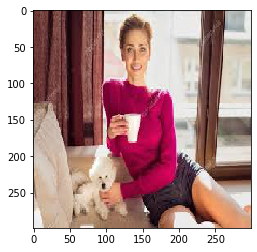

argmax:

a woman sitting on a couch with a stuffed animal .

samples:

a woman sitting on a couch with a baby in her lap .
a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch with a dog .
a woman sitting on a couch with a cat .
a woman sitting on a couch with a baby in her lap .

beam search:

a woman sitting on a couch with a stuffed bear .

top 3

a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch with a stuffed bear .
a young girl sitting on a couch with a stuffed animal .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=3)

In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 03:03:07 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


argmax:

a man in a white shirt and a white soccer ball

samples:

a man in a white shirt and white shorts playing soccer .
a man in a white shirt and a white soccer ball
a man in a soccer uniform kicking a soccer ball .
a man in white shirt and white shorts playing soccer .
a man in a soccer uniform kicking a soccer ball .

beam search:

a man in a soccer uniform kicking a soccer ball .

top 3

a man in a soccer uniform kicking a soccer ball .
a man in white shirt and white shorts playing soccer .
a man in white shirt and white shorts playing a game of soccer .


Проверим на валидационном датасете при каком размере луча beam search дает наилучший BLEU.

In [0]:
def evaluate_beam_search(model, sample=False, top_k=3, max_len=None, t=1, val_size=len(val_img_codes)):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(val_size):

            image_vectors, captions_ix_all = val_img_codes[i], train_captions[i]
            
            image_vectors = torch.tensor(image_vectors, dtype=torch.float32).to(device) 
        
            if sample:
                out = network.sample(image_vectors, max_len=max_len, st=t)
                hypotheses.append(out.split())
            else:
                out, outputs = network.beam_search(image_vectors, top_k=top_k, max_len=max_len)
                hypotheses.append(translate(out, to_str=False))

    bleu = corpus_bleu(references, hypotheses)
        
    return bleu*100

In [0]:
network.eval()
bleu_k = []
for top_k in range(2, 11):
    bleu = evaluate_beam_search(network, top_k=top_k)
    bleu_k.append(bleu)

In [0]:
bleu_k = [val_bleu] + bleu_k

In [0]:
max(bleu_k)

26.47888072806856

In [0]:
bleu_k

[24.571689227482384,
 26.28987868021969,
 26.47888072806856,
 25.852076323333062,
 25.524097962383085,
 24.842127543463484,
 24.886778402741587,
 24.54503988975932,
 24.28129221132386,
 24.254828969859172]

In [0]:
plt.title("BLEU")
plt.plot(bleu_k, label="val bleu")
plt.plot(np.argmax(bleu_k), np.max(bleu_k), marker="x", color="b", label="best bleu")
plt.xticks(np.arange(10), np.arange(1, 11))
plt.xlabel("top k")
plt.ylabel("bleu")
plt.legend()
plt.show()

Наилучший BLEU достигается при top_k=3.

## Модель с наилучшим BLEU

Теперь на тех же картинках проверим модель с наилучшим значением BLEU, полученным за время обучения:

In [0]:
# Загружаем сохраненные веса
network.load_state_dict(torch.load('/content/gdrive/My Drive/Image Captioning/v15_model_best_bleu.pt'))

<All keys matched successfully>

In [0]:
network.eval()
network = network.to(device)

2020-02-21 01:13:33 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


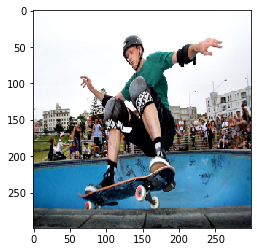

argmax:

a man riding a skateboard up the side of a ramp .

samples:

a man riding a skateboard up the side of a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard up the side of a ramp .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .

beam search:

a man riding a skateboard up a ramp .

top 3

a man riding a skateboard up a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard on top of a wooden ramp .


In [0]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, t=5, top_k=3)

In [0]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 01:14:48 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


argmax:

a cat is sitting on a couch with a stuffed animal .

samples:

a black and white cat sitting on a couch .
a cat is sitting on a couch with a stuffed animal .
a cat that is sitting on a couch .
a cat sitting on a couch with a red and white cat .
a small black and white cat sitting on a couch .

beam search:

a black and white cat sitting on a couch .

top 3

a black and white cat sitting on a couch .
a black and white cat laying on top of a couch .
a black and white cat laying on top of a red couch .


И еще картинки...

2020-02-21 01:15:26 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev [12239/12239] -> "img.jpg" [1]


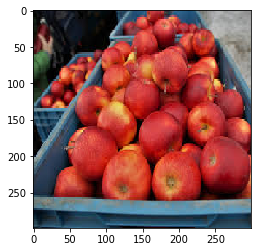

argmax:

a pile of apples sitting on top of a wooden table .

samples:

a pile of apples and oranges sitting on a table .
a bunch of apples that are sitting on a table .
a bin filled with lots of apples and oranges .
a fruit stand with apples , oranges , apples , and oranges .
a bunch of apples sitting on a table

beam search:

a bin filled with lots of apples and apples .

top 3

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a wooden table .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

Протестируем различные значения для beam search.

Для 1 получаем уже знакомый argmax:

In [0]:
generate_caption(img, mode='beam search', top_k=1)

a pile of apples sitting on top of a wooden table .

top 1

a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=2)

a pile of apples sitting on top of a table .

top 2

a pile of apples sitting on top of a table .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=3)

a bin filled with lots of apples and apples .

top 3

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=4)

a bin filled with lots of apples and apples .

top 4

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=5)

a pile of apples sitting on top of a table .

top 5

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .


In [0]:
generate_caption(img, mode='beam search', top_k=6)

a pile of apples sitting on top of a table .

top 6

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .
a bin filled with lots of apples sitting on top of a table .


In [0]:
generate_caption(img, mode='beam search', top_k=7)

a pile of apples sitting on top of a table .

top 7

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a table .
a pile of oranges sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .
a bin filled with lots of apples sitting on top of a table .


In [0]:
generate_caption(img, mode='beam search', top_k=8)

a pile of apples sitting on top of a table .

top 8

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a table .
a pile of oranges sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .
a pile of oranges sitting on top of a pile of apples .
a bin filled with lots of apples sitting on top of a table .


In [0]:
generate_caption(img, mode='beam search', top_k=9)

a pile of apples sitting on top of a table .

top 9

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a pile of apples sitting on top of a table .
a pile of oranges sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .
a pile of oranges sitting on top of a pile of apples .
a pile of apples sitting on top of a pile of apples .
a bin filled with lots of apples sitting on top of a table .


In [0]:
generate_caption(img, mode='beam search', top_k=10)

a pile of apples sitting on top of a pile of apples .

top 10

a bin filled with lots of apples and oranges .
a bin filled with lots of apples and apples .
a bin filled with lots of different types of apples .
a pile of apples sitting on top of a table .
a pile of oranges sitting on top of a table .
a pile of apples sitting on top of a wooden table .
a pile of oranges sitting on top of a wooden table .
a pile of oranges sitting on top of a pile of apples .
a pile of apples sitting on top of a pile of apples .
a bin filled with lots of apples sitting on top of a table .


2020-02-21 01:26:35 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k [9632/9632] -> "img.jpg" [1]


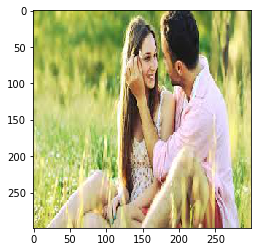

argmax:

a woman and a woman sitting on a bench .

samples:

a woman is sitting on a bench with her cell phone .
a woman and a woman are sitting on a bench .
a woman and a baby are sitting on a bench .
a woman and a woman are sitting on a bench .
a woman in a dress shirt and a man with a cell phone .

beam search:

a woman and a woman sitting on a bed .

top 3

a woman and a woman sitting on a bench .
a woman and a woman sitting on a bed .
a woman sitting on a bench with a cell phone .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 01:30:12 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 [11513/11513] -> "img.jpg" [1]


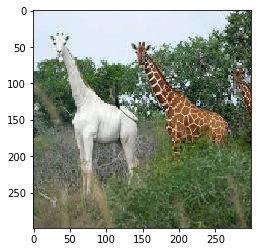

argmax:

a giraffe standing in a field of grass .

samples:

a giraffe standing in a field of grass .
a giraffe standing in a field with a tree in the background .
a large white horse standing in a field .
a white horse standing in a field of grass .
a giraffe standing in a field with a tree in the background .

beam search:

a white horse standing next to a white horse .

top 5

a large white horse standing in a field .
a couple of giraffe standing next to each other .
a white horse standing next to a white horse .
a couple of giraffe standing next to each other in a field .
a couple of giraffe standing next to each other on a lush green field .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=5, t=5)

2020-02-21 01:30:49 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB [14304/14304] -> "img.jpg" [1]


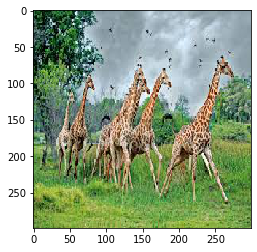

argmax:

a group of giraffes standing in a field .

samples:

a group of giraffe standing next to each other on a field .
a group of giraffes standing in a field .
a group of giraffes standing in a field .
a group of giraffe standing next to each other on a field .
a group of giraffes standing in a field .

beam search:

a group of giraffe standing next to each other .

top 3

a group of giraffe standing next to each other .
a group of giraffe standing next to each other on a field .
a group of giraffe standing next to each other on a lush green field .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-21 01:35:54 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl [12524/12524] -> "img.jpg" [1]


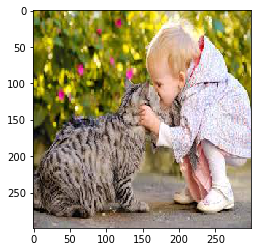

argmax:

a woman is holding a baby sheep in her hand .

samples:

a woman is holding a baby sheep in her hand .
a woman is holding a baby sheep in her hand .
a woman in a gray sweater holding a sheep .
a woman is holding a baby sheep in a field .
a woman is holding a baby sheep in her hand .

beam search:

a woman is holding a sheep in her hand

top 5

a woman is holding a sheep in her hand
a woman is holding a sheep in her hand .
a woman is holding a cat in her arms .
a woman is holding a baby in her arms .
a woman is holding a baby sheep in her hand .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=5, t=4)

2020-02-21 01:38:08 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


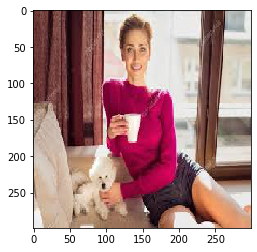

argmax:

a woman sitting on a couch with a stuffed animal .

samples:

a woman sitting on a couch with a teddy bear .
a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch with a stuffed animal .

beam search:

a woman sitting on a couch holding a stuffed bear .

top 10

a woman sitting on a couch with a dog .
a woman sitting on a couch holding a baby .
a woman sitting on a couch with a cat .
a woman sitting on a couch holding a stuffed animal .
a woman sitting on a couch with a stuffed animal .
a woman sitting on a couch holding a stuffed bear .
a woman sitting on a couch with a stuffed bear .
a young boy sitting on a couch with a stuffed animal .
a young girl sitting on a couch with a stuffed animal .
a little girl sitting on a couch with a stuffed animal .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=10, t=4)

2020-02-21 01:39:16 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


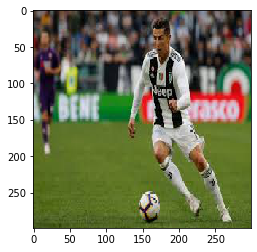

argmax:

a man in a white uniform is playing soccer

samples:

a man in a white uniform is playing soccer
a man is playing soccer on a soccer field .
a man in white shirt and white shorts playing soccer .
a man in a white shirt and white shorts playing soccer .
a man in a white shirt and shorts playing a game of soccer .

beam search:

a couple of men playing a game of soccer

top 3

a couple of men playing a game of soccer
a couple of men playing a game of soccer .
a couple of men playing a game of soccer on a field .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

Проверим на валидационном датасете при каком размере луча beam search дает наилучший BLEU.

In [0]:
def evaluate_beam_search(model, sample=False, top_k=3, max_len=None, t=1, val_size=len(val_img_codes)):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(val_size):

            image_vectors, captions_ix_all = val_img_codes[i], train_captions[i]
            
            image_vectors = torch.tensor(image_vectors, dtype=torch.float32).to(device) 
        
            if sample:
                out = network.sample(image_vectors, max_len=max_len, st=t)
                hypotheses.append(out.split())
            else:
                out, outputs = network.beam_search(image_vectors, top_k=top_k, max_len=max_len)
                hypotheses.append(translate(out, to_str=False))

    bleu = corpus_bleu(references, hypotheses)
        
    return bleu*100

In [0]:
network.eval()
bleu_k = []
for top_k in range(2, 11):
    bleu = evaluate_beam_search(network, top_k=top_k)
    bleu_k.append(bleu)

In [0]:
bleu_k = [best_bleu] + bleu_k

In [0]:
max(bleu_k)

27.095162259563278

In [0]:
bleu_k

[25.077654246070946,
 26.81271104955268,
 27.095162259563278,
 26.94909297794368,
 26.610215054819857,
 26.142835717220297,
 25.654994418667755,
 25.33343096167089,
 25.207415023086217,
 24.916819526982373]

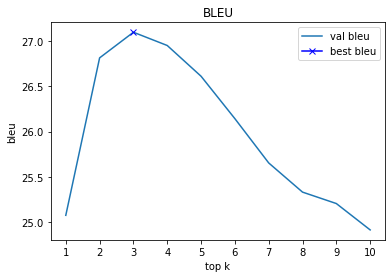

In [0]:
plt.title("BLEU")
plt.plot(bleu_k, label="val bleu")
plt.plot(np.argmax(bleu_k), np.max(bleu_k), marker="x", color="b", label="best bleu")
plt.xticks(np.arange(10), np.arange(1, 11))
plt.xlabel("top k")
plt.ylabel("bleu")
plt.legend()
plt.show()

Наилучший BLEU достигается при top_k=3.